Reprendre les codes de chatbot.ipynb avec le dataset.tsv, écrire le programme qui fait l'évaluation

In [1]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d

from scipy.spatial import distance

In [2]:
def sep_ponct(my_str, rule = r"[.,?!]"): #rule = r"([.,?!])" pour garder les ponctuations
    """separer les mots avec les char de ponctuation""" 
    #print(my_str)
    sp0 = re.split(rule, my_str)
    sp1 = [data.strip() for data in sp0]
    res = [data for data in sp1 if (data != '') ]
    return res

In [3]:
data=pd.read_csv('data.tsv',sep='\t')
dataQ=data.Question
dataA=data.Answer
Q,A=[],[]

Q2W=[]# liste de mots pour chaque phrase 
A2W=[]

for each in dataQ: 
    q = each.lower()
    Q.append(q)
    each_list = sep_ponct(q)
    remisEsp = ' '.join(each_list)
    Q2W.append(remisEsp.split(" "))
        
for each in dataA:
    a = each.lower()
    A.append(a)
    each_list = sep_ponct(a)
    remisEsp = ' '.join(each_list)
    A2W.append(remisEsp.split(" "))

In [4]:
data.describe()

,Question,Answer
count,10559,10559
unique,10191,826
top,Tell me a joke,It's nice to have things you love.
freq,46,299


In [5]:
import gensim, logging

In [6]:
window_size=2
N=len(Q2W)
vector_size=3
tout=Q2W+A2W
model=gensim.models.Word2Vec(tout,vector_size=vector_size, window=2, min_count=1, workers=4)

In [7]:
from spellchecker import SpellChecker

In [8]:
def motInconnu(mot):
    try:
        model.wv.get_vector(mot.lower())   
    except:
        spell = SpellChecker()
        mot=str(mot)
        #model.build_vocab([[str(mot)]], update=True)
        #UpdateMatrice
        print("We can't understand this word ",mot,". Do you want to say this word ",'\'',spell.correction(mot),'\'')
        print("Please enter the correct word ! ")
        x = str(input())
        return x,False
    return mot,True
              
#a,b=motInconnu("name")
#a
#false: le mot entre est le correct  

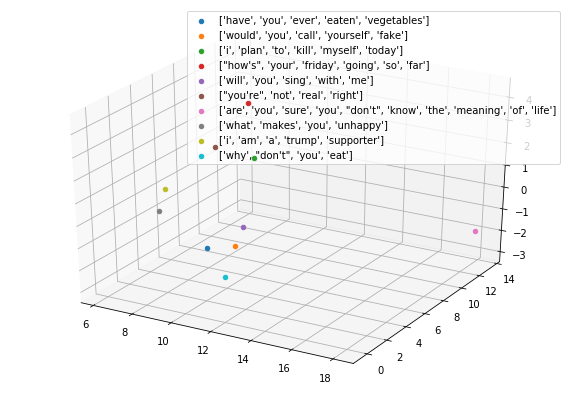

In [9]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
V=[]
for i in range (N):
    s=np.zeros(vector_size)
    for j in range(len(Q2W[i])):
        motInconnu(Q2W[i][j])
        wv=np.array(model.wv.get_vector(Q2W[i][j]))
        s+=wv
    V.append(list(s))
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
for i in range(10):
    ax.scatter3D(V[i][0],V[i][1],V[i][2],label=Q2W[i])
    #ax.scatter3D(V[i][0],V[i][1],V[i][2])
plt.legend()


In [10]:
class Kmoyennes:

    def __init__(self,K, IterationMax=20):
        self.K=K
        self.N=0
        self.D=0
        self.IterationMax = IterationMax
        self.affectations = np.zeros((self.N))
        self.representants = np.zeros((self.K,self.D))

    def fit(self,X):
        self.N = X.shape[0]
        self.D = X.shape[1]
        representants_initiaux = np.random.random((self.K,self.D))
        representants = representants_initiaux       
        for iterations in range(self.IterationMax):
            affectations = self.maj_affectations(X, representants)
            representants = self.maj_representants(X, affectations)
        self.representants = representants
        self.affectations = affectations
        return self.representants
        
    def dist(self,x1,x2):
            return np.sum((x1-x2)**2)**0.5
        
    def maj_affectations(self, X, r):
        a = np.zeros((self.N))
        for n in range(self.N):
            distances = np.zeros(self.K)
            for k in range(self.K):
                distances[k] = distance.cosine(X[n], r[k])
            a[n] = np.argmin(distances, axis=0)
        return a

    def barycentre(self,X):
        Nselection = X.shape[0]
        if Nselection != 0:
            resultat = X.sum(axis=0)/Nselection
        else:
            resultat = X.sum(axis=0)*0.0
        return resultat
    
    def maj_representants(self, X, a):       
        r = np.zeros((self.K,self.D))
        for k in range(self.K):
            masque = (a==k) ## cette condition booléenne permet d'obtenir un masque 
            r[k] = self.barycentre(X[masque])
        return r

In [11]:
def classifier(X,K,model = Kmoyennes, iterMax=10 ):
    Km = model(K=K, IterationMax=iterMax)
    Km.fit(X=X)
    affectations = Km.affectations
    representants = Km.representants
    return affectations, representants

In [12]:
X=np.array(V)
K = 10
affectations,representants = classifier(X, K = K)

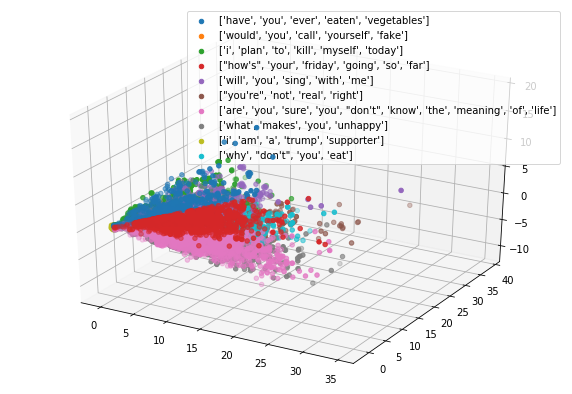

In [13]:
#print(affectations,representants)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
G=[]
for k in range(K):
    g0 = affectations==k
    G.append(X[g0])
    ax.scatter3D(X[g0,0],X[g0,1],X[g0,2],label=Q2W[k])
plt.legend()


In [14]:

def nearestVector(vector,groupe):
    minimum=distance.cosine(groupe[0],vector)
    index=0
    for i in range(len(vector)):
        vector[i]=float(vector[i])
    for i in range(len(groupe)):
        #print(distance.cosine(groupe[i],vector))
        if (distance.cosine(groupe[i],vector)<minimum):
            minumum=distance.cosine(vector,groupe[i])
            index=i
    return index              

In [15]:
def getQVsomme(tab):
    s=np.zeros(vector_size)
    for each in tab:      
        wv=np.array(model.wv.get_vector(each))
        s+=wv
    return list(s)

#### Evaluation

In [16]:
#ratio_train = 0.8
ratio_test = 0.2
#et pour valid dataset ??

Nv = len(V)
Nt = int(Nv*ratio_test)
Ntrain =  Nv- Nt
print("test size = ", Nt, ",  data size = ", Nv)

X_test = np.array(V[-Nt:].copy())
X_train = np.array(V[0:Ntrain].copy())

print(X_test.shape, "  ", X_train.shape)

test size =  2111 ,  data size =  10559
(2111, 3)    (8448, 3)


In [17]:
#Combien de questions sont déjà parmi les train ?
testC = np.array([[i,q] for i,q in enumerate(X_test) if q not in X_train], dtype = object)
nbI = Nt - testC.shape[0]
print("there is ", nbI, " questions in both X_test and X_train \n") 
print(testC.shape)
print(testC[0])
testC[:0]

there is  143  questions in both X_test and X_train 

(1968, 2)
[1 array([13.23250318,  9.11296982, -0.72221318])]


array([], shape=(0, 2), dtype=object)

In [18]:
import random

nbSamp = 10
#choisir aleatoirement 100 questions qui ne sont pas dans X_train mais dans X_test
sampIdx = random.sample(list(testC[:,0]), k = nbSamp)
print(len(set(sampIdx)), '==', nbSamp)
print(dataQ[np.array(sampIdx)+X_train.shape[0]])

def get_samples(testSet, dataQ, Ntrain, nbSample = 100):
    #testSet array avec premier colonne = indice, deuxieme colone = valeur
    sampIdx = random.sample(list(testC[:,0]), k = nbSample)
    print(len(set(sampIdx)), '==', nbSample)
    return dataQ[np.array(sampIdx)+ Ntrain]

10 == 10
8557                   That is very clever
9570                Should I take the bus?
9635                      Blessed Solstice
10245                    Who's your crush?
9738       Do you know how to play a game?
9604                      Glad to know you
9536                    Do something funny
10538                       Siri is better
9026                        I love glasses
10231    Is someone around to speak to me?
Name: Question, dtype: object


In [29]:
samples0 = get_samples(testC, dataQ, Ntrain)
samples1 = get_samples(testC, dataQ, Ntrain)

100 == 100
100 == 100


In [31]:
def chatbot_score(samples, tsvFile = "QA2score.tsv", seuil=0.06):
    nonAnswer = 0
    
    with open(tsvFile,'w+',encoding="utf8")as t:
        for each in samples:
            t.write(each + '\t')
            
            Q= each.lower()
            q = sep_ponct(Q)
            tab = ' '.join(q).split()
                             
            for i in range(len(tab)):
                tab[i],b=motInconnu(tab[i])
                while(b==False):
                    tab[i],b=motInconnu(tab[i])
            QV=getQVsomme(tab)
        
            if QV in X_train:
                print("sample error: give me some questions out of X_train for test please!")
                print(QV, each," \n current nonAnswer = ",nonAnswer )
                print(QV in testC)
                return
        
            nearestRepresentanrs=nearestVector(QV,representants) 
            g0 = affectations==nearestRepresentanrs
            nearestIndexCloture=nearestVector(QV,X[g0])
            if(distance.cosine(list(X[g0][nearestIndexCloture]),QV)>seuil):
                nonAnswer +=1
                t.write('non Answer-------------------- \n')
            else:
                nearestIndex=V.index(list(X[g0][nearestIndexCloture]))
                t.write( dataA[nearestIndex]+ '\n')
        
    return nonAnswer

In [33]:
noAnswer = chatbot_score(samples0)
no2 = chatbot_score(samples1, tsvFile = "qa2.tsv")
noAnswer, no2

(10, 15)

#0.07307243670603059: distance what's your name vs answer 
#0.06816835295193202: distance red vs orange

In [32]:
def chatbotSansClass_score(samples,tsvFile = "QA2score_sansClass.tsv", seuil=0.06):
    nonAnswer = 0
    
    with open(tsvFile,'w+',encoding="utf8")as t:
        for each in samples:
            t.write(each + '\t')
            
            Q= each.lower()
            q = sep_ponct(Q)
            tab = ' '.join(q).split()
                             
            for i in range(len(tab)):
                tab[i],b=motInconnu(tab[i])
                while(b==False):
                    tab[i],b=motInconnu(tab[i])
            QV=getQVsomme(tab)
        
            if QV in X_train:
                print("sample error: give me some questions out of X_train for test please!")
                print(QV, each," \n current nonAnswer = ",nonAnswer )
                print(QV in testC)
                return
            
            nearestIndex=nearestVector(QV,V)
            if(distance.cosine(V[nearestIndex],QV)>seuil):
                nonAnswer +=1
                t.write('non Answer-------------------- \n')
            else:
                t.write( dataA[nearestIndex]+ '\n')
        
    return nonAnswer

In [35]:
noAnswer0 = chatbotSansClass_score(samples0)
noA1 = chatbotSansClass_score(samples1, tsvFile = "qa2SansClass.tsv")
noAnswer0,noA1

(24, 30)

#### test

- le chatbot reconnait "how was your day?" et "how was your day"  mais not "how was your day??" 

   ---- supprimer les ponctuation

In [24]:
#seuil=0.06
def chatbot(question, seuil = 0.06):
    Q= question.lower()
    q = sep_ponct(Q)
    tab = ' '.join(q).split()
                             
    for i in range(len(tab)):
        tab[i],b=motInconnu(tab[i])
        while(b==False):
            tab[i],b=motInconnu(tab[i])
    QV=getQVsomme(tab)
    
    for i in range(len(X_train)):
        if QV==list(X_train[i]):
            nearestIndex=V.index(QV)
            return dataA[nearestIndex]
        
    nearestRepresentanrs=nearestVector(QV,representants) 
    g0 = affectations==nearestRepresentanrs
    nearestIndexCloture=nearestVector(QV,X[g0])
    nearestIndex=V.index(list(X[g0][nearestIndexCloture]))
    #print(distance.cosine(list(X[g0][nearestIndexCloture]),QV))
    if(distance.cosine(list(X[g0][nearestIndexCloture]),QV)>seuil):
        return "I am so sorry, I can't give an answer "
    return dataA[nearestIndex] 

In [25]:
def letsChat(ModelChatbot):
    goodBye = ['bye', 'goodbye','have a nice day','see you']
    print("Ask me something! ")
    chat = True
    while(chat):
        Q = str(input()) #entrer une phrase
        if(Q.lower() in goodBye):
            print(Q)
            return
        answer = ModelChatbot(Q)
        print(answer) 

In [26]:
#letsChat(chatbot)

In [27]:
def chatbotSansClassification(question, seuil = 0.06):
    Q= question.lower()
    q = sep_ponct(Q)
    tab = ' '.join(q).split()
                             
    for i in range(len(tab)):
        tab[i],b=motInconnu(tab[i])
        while(b==False):
            tab[i],b=motInconnu(tab[i])
    QV=getQVsomme(tab)
    
    for i in range(len(X_train)):
        if QV==list(X_train[i]):
            nearestIndex=V.index(QV)
            #print("here in train, QV = ", QV)
            return dataA[nearestIndex]
        
    nearestIndex=nearestVector(QV,V)
    if(distance.cosine(V[nearestIndex],QV)>seuil):
        return "I am so sorry, I can't give an answer "
    return dataA[nearestIndex] 

In [28]:
#letsChat(chatbotSansClassification)